# Road Accident Severity Classification


In [4]:
pip install tensorflow

In [5]:
#import the necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pickle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
collision_df = pd.read_csv("/content/dft-road-casualty-statistics-collision-2022.csv")
vehicle_df = pd.read_csv("/content/dft-road-casualty-statistics-vehicle-2022.csv")

In [7]:
collision_df = collision_df.replace(-1,pd.NA).replace('-1',pd.NA)
vehicle_df = vehicle_df.replace(-1,pd.NA).replace('-1',pd.NA)

In [8]:
print(collision_df.shape)
print(vehicle_df.shape)

(106004, 36)
(193545, 28)


In [9]:
collision_df.isna().sum()

accident_index                                      0
accident_year                                       0
accident_reference                                  0
location_easting_osgr                              22
location_northing_osgr                             22
longitude                                          22
latitude                                           22
police_force                                        0
accident_severity                                   0
number_of_vehicles                                  0
number_of_casualties                                0
date                                                0
day_of_week                                         0
time                                                0
local_authority_district                       106004
local_authority_ons_district                        0
local_authority_highway                             0
first_road_class                                    0
first_road_number           

In [10]:
vehicle_df.isna().sum()

accident_index                          0
accident_year                           0
accident_reference                      0
vehicle_reference                       0
vehicle_type                          271
towing_and_articulation              1665
vehicle_manoeuvre                    2320
vehicle_direction_from               4059
vehicle_direction_to                 4082
vehicle_location_restricted_lane     2394
junction_location                     984
skidding_and_overturning             2441
hit_object_in_carriageway            2418
vehicle_leaving_carriageway          2444
hit_object_off_carriageway            575
first_point_of_impact                2787
vehicle_left_hand_drive                 0
journey_purpose_of_driver               0
sex_of_driver                           0
age_of_driver                       29295
age_band_of_driver                  29295
engine_capacity_cc                  45173
propulsion_code                     42847
age_of_vehicle                    

In [11]:
df_merged = pd.merge(collision_df,vehicle_df,how='inner',on=['accident_index','accident_year','accident_reference'])

In [12]:
df_merged.shape

(8647, 61)

In [13]:
df_merged.columns

Index(['accident_index', 'accident_year', 'accident_reference',
       'location_easting_osgr', 'location_northing_osgr', 'longitude',
       'latitude', 'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'date', 'day_of_week', 'time',
       'local_authority_district', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_accident_location', 'vehicle_reference',
       'vehicle_type', 'towing_and_articulation', 'vehicle_manoeuvre',
     

In [14]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8647 entries, 0 to 8646
Data columns (total 61 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   accident_index                               8647 non-null   object 
 1   accident_year                                8647 non-null   int64  
 2   accident_reference                           8647 non-null   object 
 3   location_easting_osgr                        8638 non-null   float64
 4   location_northing_osgr                       8638 non-null   float64
 5   longitude                                    8638 non-null   float64
 6   latitude                                     8638 non-null   float64
 7   police_force                                 8647 non-null   int64  
 8   accident_severity                            8647 non-null   int64  
 9   number_of_vehicles                           8647 non-null   int64  
 10  

In [15]:
df = df_merged[['accident_severity','number_of_vehicles','number_of_casualties','date','day_of_week','time','speed_limit','junction_detail',
                'first_road_class','light_conditions','weather_conditions','road_surface_conditions','urban_or_rural_area','vehicle_manoeuvre',
               'lsoa_of_accident_location','vehicle_type','sex_of_driver','age_band_of_driver','age_of_vehicle','vehicle_leaving_carriageway',
               ]]

In [16]:
df.describe(include="all")

,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,speed_limit,junction_detail,first_road_class,light_conditions,weather_conditions,road_surface_conditions,urban_or_rural_area,vehicle_manoeuvre,lsoa_of_accident_location,vehicle_type,sex_of_driver,age_band_of_driver,age_of_vehicle,vehicle_leaving_carriageway
count,8647.000000,8647.000000,8647.000000,8647,8647.000000,8647,8647.000000,8647.000000,8647.000000,8647.0,8647.000000,8637.0,8647.000000,8647.0,8636,8647.0,8647.000000,7822.0,6503.0,8647.0
unique,NaN,NaN,NaN,365,NaN,1040,NaN,NaN,NaN,5.0,NaN,5.0,NaN,18.0,1740,20.0,NaN,11.0,46.0,9.0
top,NaN,NaN,NaN,16/12/2022,NaN,17:00,NaN,NaN,NaN,1.0,NaN,1.0,NaN,18.0,E01032979,9.0,NaN,6.0,7.0,0.0
freq,NaN,NaN,NaN,48,NaN,118,NaN,NaN,NaN,6393.0,NaN,6222.0,NaN,4657.0,48,6225.0,NaN,1585.0,451.0,7317.0
mean,2.706950,2.093790,1.423037,NaN,4.216376,NaN,42.184573,2.113103,4.047762,NaN,1.482711,NaN,1.587024,NaN,NaN,NaN,1.403839,NaN,NaN,NaN
std,0.517942,0.831024,0.871088,NaN,1.958042,NaN,15.215445,2.606141,1.395826,NaN,1.528175,NaN,0.494507,NaN,NaN,NaN,0.599540,NaN,NaN,NaN
min,1.000000,1.000000,1.000000,NaN,1.000000,NaN,20.000000,0.000000,1.000000,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
25%,2.000000,2.000000,1.000000,NaN,3.000000,NaN,30.000000,0.000000,3.000000,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
50%,3.000000,2.000000,1.000000,NaN,4.000000,NaN,30.000000,1.000000,3.000000,NaN,1.000000,NaN,2.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
75%,3.000000,2.000000,2.000000,NaN,6.000000,NaN,60.000000,3.000000,6.000000,NaN,1.000000,NaN,2.000000,NaN,NaN,NaN,2.000000,NaN,NaN,NaN


In [17]:
df.groupby('accident_severity').size()

accident_severity
1     264
2    2006
3    6377
dtype: int64

## Data Preprocessing

In [18]:
df.isnull().sum()

accident_severity                 0
number_of_vehicles                0
number_of_casualties              0
date                              0
day_of_week                       0
time                              0
speed_limit                       0
junction_detail                   0
first_road_class                  0
light_conditions                  0
weather_conditions                0
road_surface_conditions          10
urban_or_rural_area               0
vehicle_manoeuvre                 0
lsoa_of_accident_location        11
vehicle_type                      0
sex_of_driver                     0
age_band_of_driver              825
age_of_vehicle                 2144
vehicle_leaving_carriageway       0
dtype: int64

In [19]:
df['light_conditions'].fillna(df['light_conditions'].mode()[0], inplace=True)
df['age_band_of_driver'].fillna(df['age_band_of_driver'].mode()[0], inplace=True)
df['vehicle_type'].fillna(df['vehicle_type'].mode()[0], inplace=True)
df['road_surface_conditions'].fillna(df['road_surface_conditions'].mode()[0], inplace=True)
df['vehicle_manoeuvre'].fillna(df['vehicle_manoeuvre'].mode()[0], inplace=True)
df['age_of_vehicle'].fillna(df['age_of_vehicle'].mean(), inplace=True)
df['vehicle_leaving_carriageway'].fillna(df['vehicle_leaving_carriageway'].mode()[0], inplace=True)

In [20]:
mapping = {1: 0, 2: 1, 3: 2}
df['accident_severity'] = df['accident_severity'].map(mapping)

In [21]:
df.duplicated().sum()

18

In [22]:
df.drop_duplicates(inplace=True)

In [23]:
df.head()

,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,speed_limit,junction_detail,first_road_class,light_conditions,weather_conditions,road_surface_conditions,urban_or_rural_area,vehicle_manoeuvre,lsoa_of_accident_location,vehicle_type,sex_of_driver,age_band_of_driver,age_of_vehicle,vehicle_leaving_carriageway
0,2,2,2,29/06/2022,4,13:18,30,0,3,1,1,1,1,12,E01012204,9,2,6,0.000000,0
1,2,2,2,29/06/2022,4,13:18,30,0,3,1,1,1,1,18,E01012204,9,1,7,12.000000,0
2,1,2,1,09/01/2022,1,18:18,30,8,6,4,2,2,1,9,E01012058,9,3,6,9.138244,0
3,1,2,1,09/01/2022,1,18:18,30,8,6,4,2,2,1,18,E01012058,1,1,8,9.138244,0
4,0,2,1,04/01/2022,3,15:19,30,0,6,1,1,2,1,13,E01011955,90,1,5,9.138244,7


### Numerical data analysis

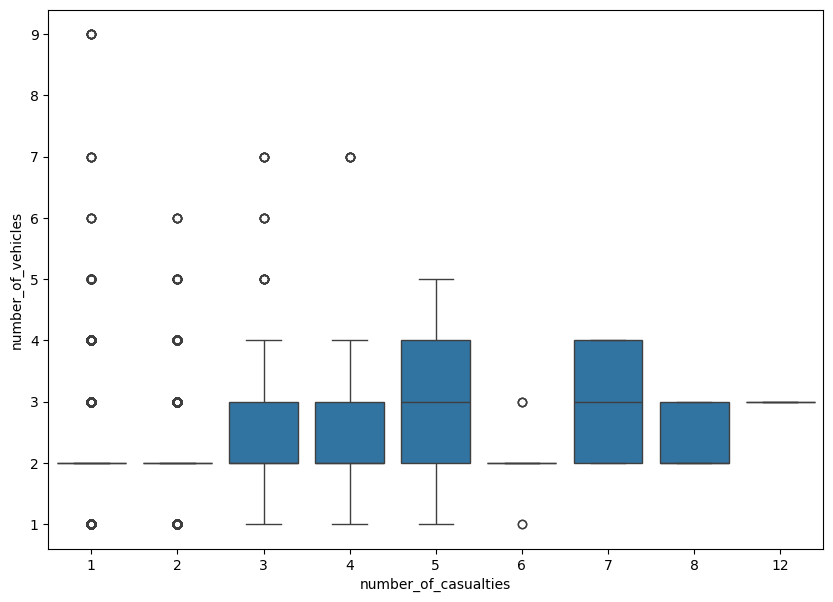

In [24]:
plt.figure(figsize=(10,7))
sns.boxplot(data=df, y='number_of_vehicles', x='number_of_casualties')
plt.show()

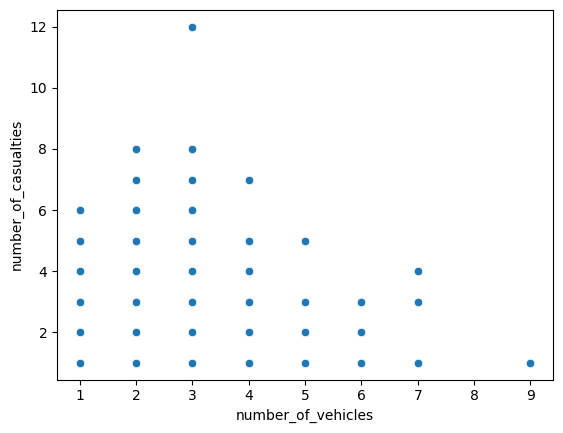

In [25]:
sns.scatterplot(x=df['number_of_vehicles'], y=df['number_of_casualties'])
plt.show()

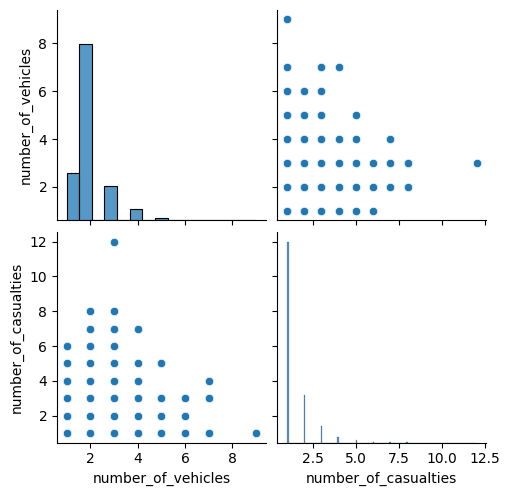

In [26]:
sns.pairplot(df[['number_of_vehicles','number_of_casualties']])
plt.show()

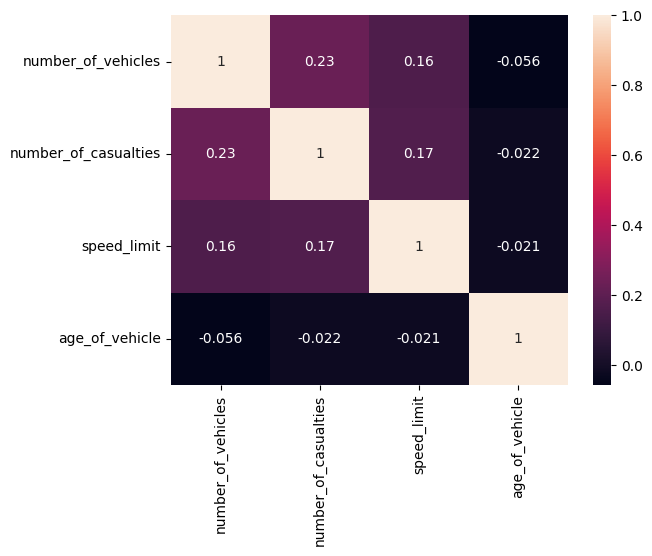

In [27]:
correlation_matrix = df[['number_of_vehicles','number_of_casualties','speed_limit','age_of_vehicle']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

### Categorical data analysis

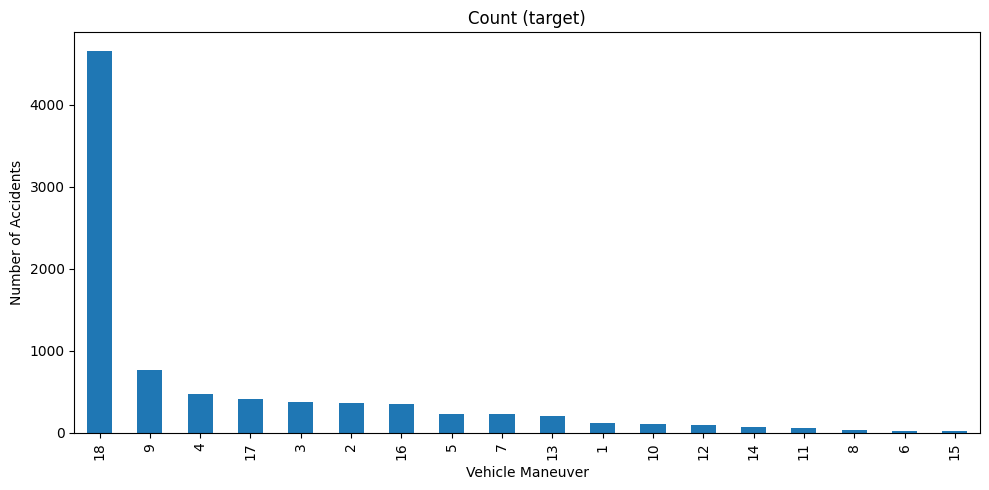

In [28]:
plt.figure(figsize=(10, 5))
target_count = df['vehicle_manoeuvre'].value_counts()
target_count.plot(kind='bar', title='Count (target)')
plt.xlabel('Vehicle Maneuver')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

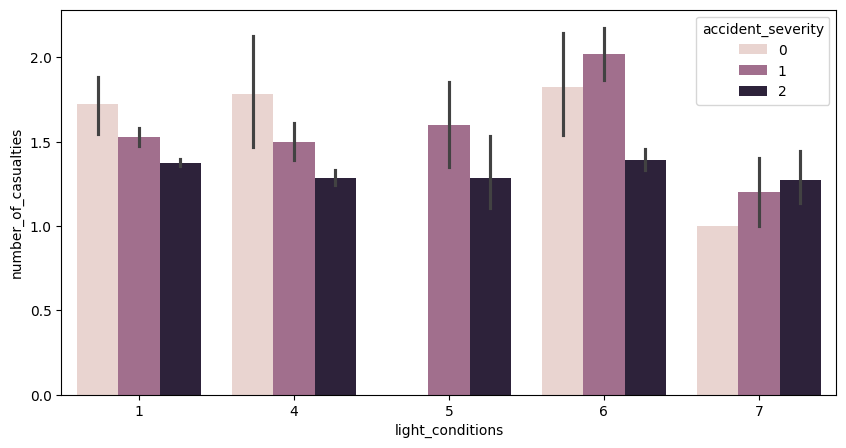

In [29]:
plt.figure(figsize=(10, 5))
sns.barplot(x="light_conditions", y="number_of_casualties", hue="accident_severity", data=df)
plt.show()

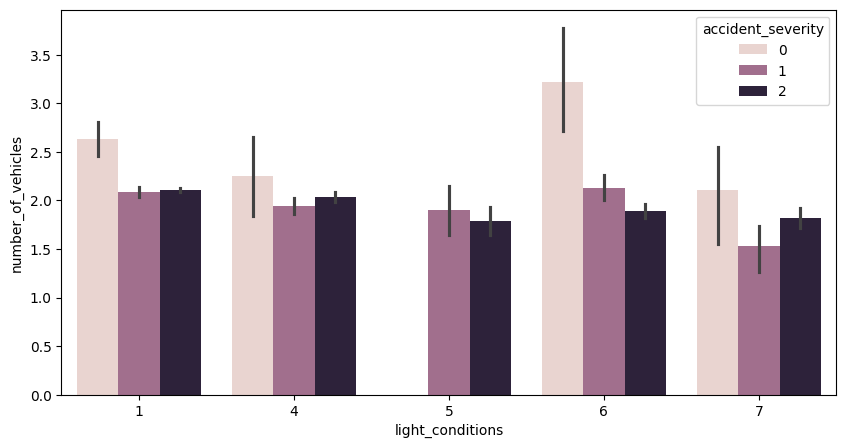

In [30]:
plt.figure(figsize=(10, 5))
sns.barplot(x="light_conditions", y="number_of_vehicles", hue="accident_severity", data=df)
plt.show()

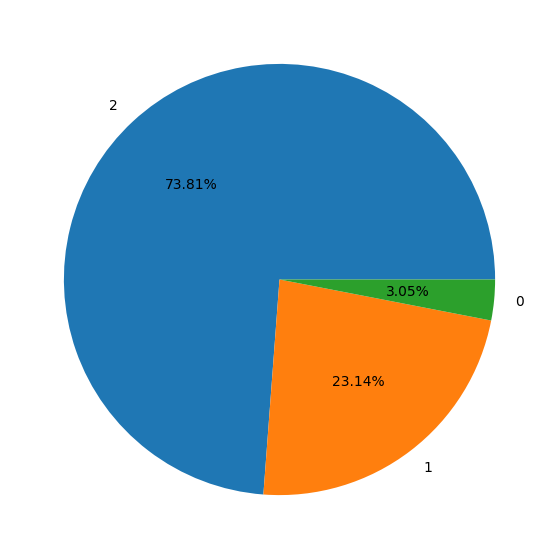

In [31]:
plt.figure(figsize=(10,7))
plt.pie(x=df['accident_severity'].value_counts().values,
        labels=df['accident_severity'].value_counts().index,
        autopct='%2.2f%%')
plt.show()

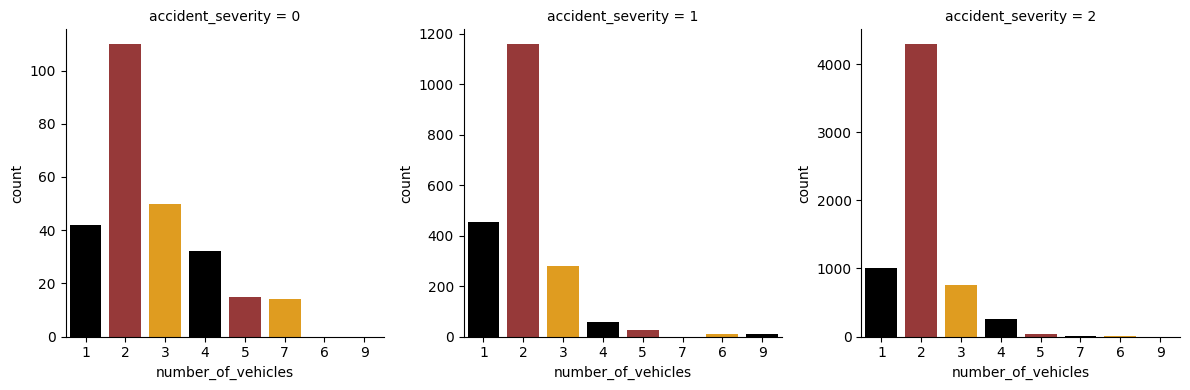

In [32]:
grid = sns.FacetGrid(data=df, col='accident_severity', height=4, aspect=1, sharey=False)
grid.map(sns.countplot, 'number_of_vehicles', palette=['black', 'brown', 'orange'])
plt.show()

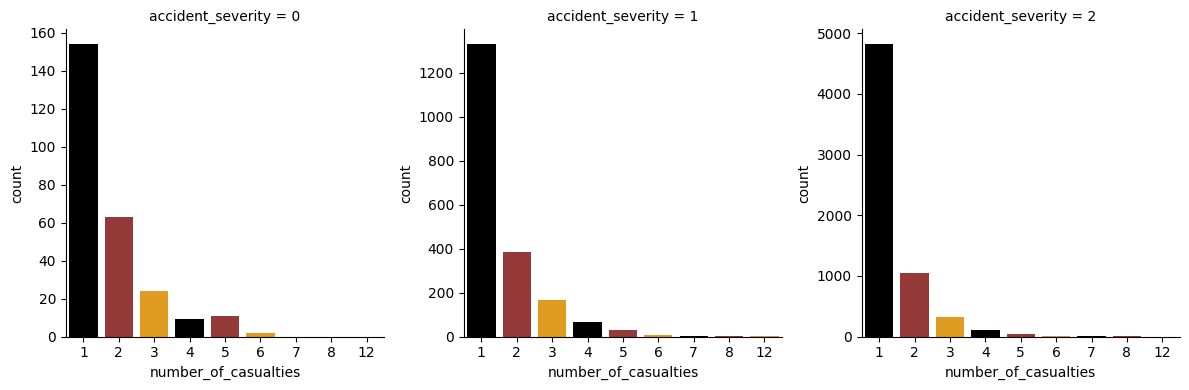

In [33]:
grid = sns.FacetGrid(data=df, col='accident_severity', height=4, aspect=1, sharey=False)
grid.map(sns.countplot, 'number_of_casualties', palette=['black', 'brown', 'orange'])
plt.show()

## Data preparation

In [34]:
fs_df = df[['accident_severity','number_of_vehicles','number_of_casualties','speed_limit',
            'light_conditions','weather_conditions','road_surface_conditions','urban_or_rural_area',
            'age_band_of_driver','age_of_vehicle','vehicle_leaving_carriageway','first_road_class',
           ]]

In [35]:
categorical_cols = ['first_road_class', 'light_conditions', 'weather_conditions',
                    'road_surface_conditions', 'urban_or_rural_area', 'age_band_of_driver',
                    'vehicle_leaving_carriageway']

onehot_encoder = OneHotEncoder(sparse=False)
encoded_features = onehot_encoder.fit_transform(fs_df[categorical_cols])
new_categorical_cols = onehot_encoder.get_feature_names_out(categorical_cols)
for col, feature in zip(new_categorical_cols, encoded_features.T):
    fs_df[col] = feature

fs_df.drop(columns=categorical_cols,inplace=True)

In [36]:
scaler = MinMaxScaler(feature_range=(0, 1))
num_cols = ['number_of_vehicles','number_of_casualties','speed_limit','age_of_vehicle']
fs_df[num_cols] = scaler.fit_transform(fs_df[num_cols])

In [37]:
fs_df.head()

,accident_severity,number_of_vehicles,number_of_casualties,speed_limit,age_of_vehicle,first_road_class_1,first_road_class_3,first_road_class_4,first_road_class_5,first_road_class_6,...,age_band_of_driver_11,vehicle_leaving_carriageway_0,vehicle_leaving_carriageway_1,vehicle_leaving_carriageway_2,vehicle_leaving_carriageway_3,vehicle_leaving_carriageway_4,vehicle_leaving_carriageway_5,vehicle_leaving_carriageway_6,vehicle_leaving_carriageway_7,vehicle_leaving_carriageway_8
0,2,0.125,0.090909,0.2,0.000000,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.125,0.090909,0.2,0.176471,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.125,0.000000,0.2,0.134386,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.125,0.000000,0.2,0.134386,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.125,0.000000,0.2,0.134386,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Train test split

In [38]:
X = fs_df.drop(['accident_severity'], axis=1)
y = fs_df['accident_severity']

In [39]:
# # upsampling using smote
# counter = Counter(y)
# print("=============================")
# for k,v in counter.items():
#     per = 100*v/len(y)
#     print(f"Class= {k}, n={v} ({per:.2f}%)")

# oversample = SMOTE()
# X, y = oversample.fit_resample(X, y)

# counter = Counter(y)
# print("=============================")
# for k,v in counter.items():
#     per = 100*v/len(y)
#     print(f"Class= {k}, n={v} ({per:.2f}%)")

# print("=============================")
# print("Upsampled data shape: ", X.shape, y.shape)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6040, 51) (2589, 51) (6040,) (2589,)


## Modelling

In [41]:
models={"LogisticRegression":LogisticRegression(),
        "DecisionTreeClassifier":DecisionTreeClassifier(),
        "KNeighborsClassifier":KNeighborsClassifier(),
        "RandomForestClassifier":RandomForestClassifier(),
        "AdaBoostClassifier":AdaBoostClassifier(),
        "GradientBoostingClassifier":GradientBoostingClassifier(),
        }

In [42]:
def run_models(models,x,y):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    model_res={}
    for name,model in models.items():
        model_pipeline=Pipeline([('model',model)])
        model_fit=model_pipeline.fit(X_train,y_train)
        y_pred=model_fit.predict(X_test)
        acc=accuracy_score(y_test,y_pred)
        print("The Accuracy for ",name," is :",acc)
        print(classification_report(y_test,y_pred))
        print(confusion_matrix(y_test,y_pred))
        print('=====================================================================')
        model_res[name]=model
    return model_res

In [43]:
acc=run_models(models,X,y)

The Accuracy for  LogisticRegression  is : 0.7292390884511394
              precision    recall  f1-score   support

           0       1.00      0.02      0.05        82
           1       0.57      0.01      0.03       624
           2       0.73      1.00      0.84      1883

    accuracy                           0.73      2589
   macro avg       0.77      0.34      0.31      2589
weighted avg       0.70      0.73      0.62      2589

[[   2    1   79]
 [   0    8  616]
 [   0    5 1878]]
The Accuracy for  DecisionTreeClassifier  is : 0.6500579374275782
              precision    recall  f1-score   support

           0       0.29      0.29      0.29        82
           1       0.34      0.34      0.34       624
           2       0.77      0.77      0.77      1883

    accuracy                           0.65      2589
   macro avg       0.47      0.47      0.47      2589
weighted avg       0.65      0.65      0.65      2589

[[  24   17   41]
 [  16  213  395]
 [  42  395 1446]]


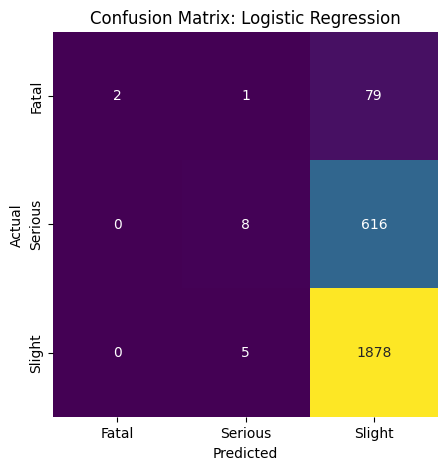

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
# Data for the confusion matrix
data_matrix = [
    [2, 1, 79],
    [0, 8, 616],
    [0, 5, 1878]
]
# Labels for the rows and columns
labels = ['Fatal', 'Serious', 'Slight']

# Convert the list to a pandas DataFrame
df_matrix = pd.DataFrame(data_matrix, index=labels, columns=labels)

# Plotting the confusion matrix using seaborn for better visual representation
plt.figure(figsize=(6, 5))
sns.heatmap(df_matrix, annot=True, fmt="d", cmap='viridis', cbar=False, square=True)
plt.title('Confusion Matrix: Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


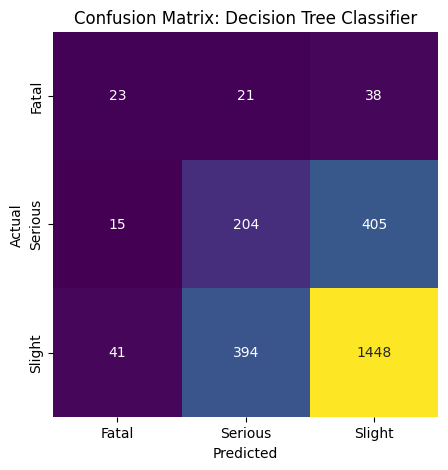

In [45]:
# Data for the confusion matrix
data_matrix = [
    [23,21,38],
    [15,204,405],
    [41,394,1448]
]
# Convert the list to a pandas DataFrame
df_matrix = pd.DataFrame(data_matrix, index=labels, columns=labels)

# Plotting the confusion matrix using seaborn for better visual representation
plt.figure(figsize=(6, 5))
sns.heatmap(df_matrix, annot=True, fmt="d", cmap='viridis', cbar=False, square=True)
plt.title('Confusion Matrix: Decision Tree Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

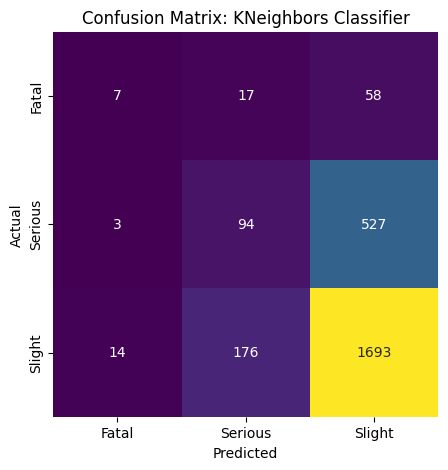

In [46]:
# Data for the confusion matrix
data_matrix = [
 [   7,   17,   58],
 [   3,   94,  527],
 [  14,  176, 1693]
]
# Convert the list to a pandas DataFrame
df_matrix = pd.DataFrame(data_matrix, index=labels, columns=labels)

# Plotting the confusion matrix using seaborn for better visual representation
plt.figure(figsize=(6, 5))
sns.heatmap(df_matrix, annot=True, fmt="d", cmap='viridis', cbar=False, square=True)
plt.title('Confusion Matrix: KNeighbors Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

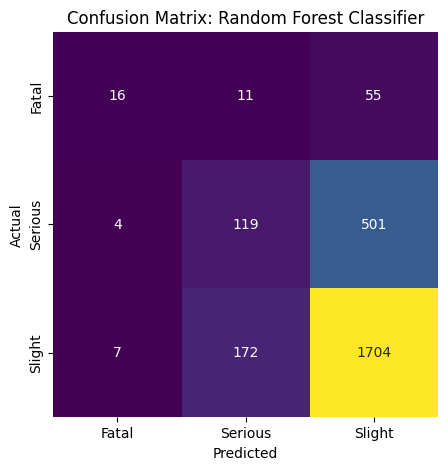

In [47]:
# Data for the confusion matrix
data_matrix = [
[  16,   11,   55],
 [   4,  119,  501],
 [   7,  172, 1704],
]
# Convert the list to a pandas DataFrame
df_matrix = pd.DataFrame(data_matrix, index=labels, columns=labels)

# Plotting the confusion matrix using seaborn for better visual representation
plt.figure(figsize=(6, 5))
sns.heatmap(df_matrix, annot=True, fmt="d", cmap='viridis', cbar=False, square=True)
plt.title('Confusion Matrix: Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

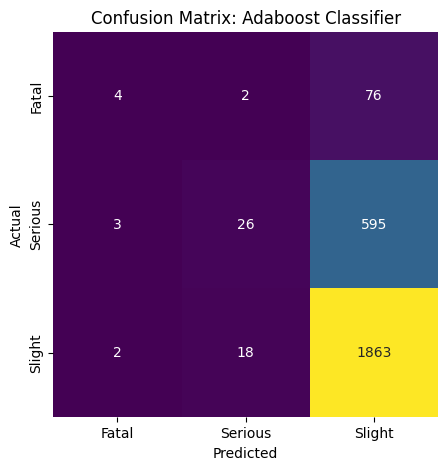

In [48]:
# Data for the confusion matrix
data_matrix = [
[   4 ,   2,   76],
 [   3 ,  26 , 595],
 [   2 ,  18, 1863]
]
# Convert the list to a pandas DataFrame
df_matrix = pd.DataFrame(data_matrix, index=labels, columns=labels)

# Plotting the confusion matrix using seaborn for better visual representation
plt.figure(figsize=(6, 5))
sns.heatmap(df_matrix, annot=True, fmt="d", cmap='viridis', cbar=False, square=True)
plt.title('Confusion Matrix: Adaboost Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

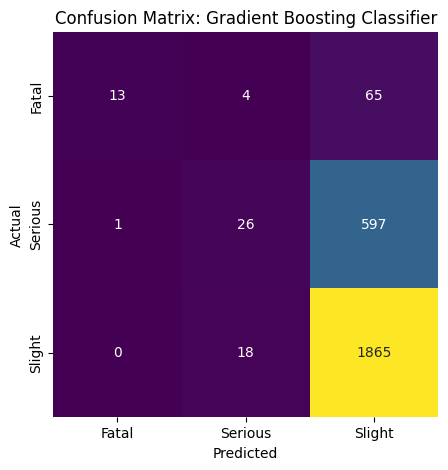

In [49]:
# Data for the confusion matrix
data_matrix = [
[  13,    4 ,  65],
 [   1   ,26 , 597],
 [   0  , 18, 1865]
]
# Convert the list to a pandas DataFrame
df_matrix = pd.DataFrame(data_matrix, index=labels, columns=labels)

# Plotting the confusion matrix using seaborn for better visual representation
plt.figure(figsize=(6, 5))
sns.heatmap(df_matrix, annot=True, fmt="d", cmap='viridis', cbar=False, square=True)
plt.title('Confusion Matrix: Gradient Boosting Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [50]:
calculated_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {label: weight for label, weight in zip(np.unique(y_train), calculated_weights)}

# Define base models with cost-sensitive learning
model1 = RandomForestClassifier(class_weight=class_weights)
model2 = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False)

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

ensemble_model = VotingClassifier(estimators=[('rf', model1), ('xgb', model2)], voting='hard')
ensemble_model.fit(X_train, y_train)
ensemble_predictions = ensemble_model.predict(X_test)


with open('ensemble_model.pkl', 'wb') as f:
    pickle.dump(ensemble_model, f)

accuracy = accuracy_score(y_test, ensemble_predictions)

print("Ensemble Model Performance:")
print("The Accuracy for Ensemble Model is :",accuracy)
print(classification_report(y_test,ensemble_predictions))
print(confusion_matrix(y_test,ensemble_predictions))

Ensemble Model Performance:
The Accuracy for Ensemble Model is : 0.6910003862495172
              precision    recall  f1-score   support

           0       0.38      0.17      0.24        82
           1       0.39      0.29      0.33       624
           2       0.76      0.85      0.80      1883

    accuracy                           0.69      2589
   macro avg       0.51      0.44      0.46      2589
weighted avg       0.66      0.69      0.67      2589

[[  14   15   53]
 [   5  180  439]
 [  18  270 1595]]


In [51]:
pd.set_option('display.max_columns',100)
X_test.head()

,number_of_vehicles,number_of_casualties,speed_limit,age_of_vehicle,first_road_class_1,first_road_class_3,first_road_class_4,first_road_class_5,first_road_class_6,light_conditions_1,light_conditions_4,light_conditions_5,light_conditions_6,light_conditions_7,weather_conditions_1,weather_conditions_2,weather_conditions_3,weather_conditions_4,weather_conditions_5,weather_conditions_6,weather_conditions_7,weather_conditions_8,weather_conditions_9,road_surface_conditions_1,road_surface_conditions_2,road_surface_conditions_3,road_surface_conditions_4,road_surface_conditions_5,urban_or_rural_area_1,urban_or_rural_area_2,urban_or_rural_area_3,age_band_of_driver_1,age_band_of_driver_2,age_band_of_driver_3,age_band_of_driver_4,age_band_of_driver_5,age_band_of_driver_6,age_band_of_driver_7,age_band_of_driver_8,age_band_of_driver_9,age_band_of_driver_10,age_band_of_driver_11,vehicle_leaving_carriageway_0,vehicle_leaving_carriageway_1,vehicle_leaving_carriageway_2,vehicle_leaving_carriageway_3,vehicle_leaving_carriageway_4,vehicle_leaving_carriageway_5,vehicle_leaving_carriageway_6,vehicle_leaving_carriageway_7,vehicle_leaving_carriageway_8
750,0.125,0.000000,0.0,0.161765,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8554,0.250,0.090909,0.8,0.029412,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
320,0.125,0.000000,0.6,0.088235,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6686,0.125,0.000000,0.2,0.134386,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6948,0.125,0.000000,0.2,0.134386,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
with open('ensemble_model.pkl', 'rb') as f:
    ensemble_model = pickle.load(f)

data = {
    "number_of_vehicles": 0.125,
    "number_of_casualties": 0.0,
    "speed_limit": 0.0,
    "age_of_vehicle": 0.161765,
    "first_road_class_1": 0.0,
    "first_road_class_3": 0.0,
    "first_road_class_4": 0.0,
    "first_road_class_5": 1.0,
    "first_road_class_6": 0.0,
    "light_conditions_1": 0.0,
    "light_conditions_4": 1.0,
    "light_conditions_5": 0.0,
    "light_conditions_6": 0.0,
    "light_conditions_7": 0.0,
    "weather_conditions_1": 1.0,
    "weather_conditions_2": 0.0,
    "weather_conditions_3": 0.0,
    "weather_conditions_4": 0.0,
    "weather_conditions_5": 0.0,
    "weather_conditions_6": 0.0,
    "weather_conditions_7": 0.0,
    "weather_conditions_8": 0.0,
    "weather_conditions_9": 0.0,
    "road_surface_conditions_1": 0.0,
    "road_surface_conditions_2": 1.0,
    "road_surface_conditions_3": 0.0,
    "road_surface_conditions_4": 0.0,
    "road_surface_conditions_5": 0.0,
    "urban_or_rural_area_1": 1.0,
    "urban_or_rural_area_2": 0.0,
    "urban_or_rural_area_3": 0.0,
    "age_band_of_driver_1": 0.0,
    "age_band_of_driver_2": 0.0,
    "age_band_of_driver_3": 0.0,
    "age_band_of_driver_4": 0.0,
    "age_band_of_driver_5": 0.0,
    "age_band_of_driver_6": 1.0,
    "age_band_of_driver_7": 0.0,
    "age_band_of_driver_8": 0.0,
    "age_band_of_driver_9": 0.0,
    "age_band_of_driver_10": 0.0,
    "age_band_of_driver_11": 0.0,
    "vehicle_leaving_carriageway_0": 1.0,
    "vehicle_leaving_carriageway_1": 0.0,
    "vehicle_leaving_carriageway_2": 0.0,
    "vehicle_leaving_carriageway_3": 0.0,
    "vehicle_leaving_carriageway_4": 0.0,
    "vehicle_leaving_carriageway_5": 0.0,
    "vehicle_leaving_carriageway_6": 0.0,
    "vehicle_leaving_carriageway_7": 0.0,
    "vehicle_leaving_carriageway_8": 0.0
}
input_df = pd.DataFrame(data, index=[0])
ensemble_prediction = ensemble_model.predict(input_df)
print(ensemble_prediction)

[2]


In [53]:
input_df

,number_of_vehicles,number_of_casualties,speed_limit,age_of_vehicle,first_road_class_1,first_road_class_3,first_road_class_4,first_road_class_5,first_road_class_6,light_conditions_1,light_conditions_4,light_conditions_5,light_conditions_6,light_conditions_7,weather_conditions_1,weather_conditions_2,weather_conditions_3,weather_conditions_4,weather_conditions_5,weather_conditions_6,weather_conditions_7,weather_conditions_8,weather_conditions_9,road_surface_conditions_1,road_surface_conditions_2,road_surface_conditions_3,road_surface_conditions_4,road_surface_conditions_5,urban_or_rural_area_1,urban_or_rural_area_2,urban_or_rural_area_3,age_band_of_driver_1,age_band_of_driver_2,age_band_of_driver_3,age_band_of_driver_4,age_band_of_driver_5,age_band_of_driver_6,age_band_of_driver_7,age_band_of_driver_8,age_band_of_driver_9,age_band_of_driver_10,age_band_of_driver_11,vehicle_leaving_carriageway_0,vehicle_leaving_carriageway_1,vehicle_leaving_carriageway_2,vehicle_leaving_carriageway_3,vehicle_leaving_carriageway_4,vehicle_leaving_carriageway_5,vehicle_leaving_carriageway_6,vehicle_leaving_carriageway_7,vehicle_leaving_carriageway_8
0,0.125,0.0,0.0,0.161765,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
model = Sequential()

model.add(Dense(units=32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

y_train_encoded = onehot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_encoded = onehot_encoder.fit_transform(y_test.to_numpy().reshape(-1, 1))

X_test_nn, X_val, y_test_nn, y_val = train_test_split(X_test, y_test_encoded, test_size=0.3, random_state=42)

model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_val, y_val))

test_loss, test_acc = model.evaluate(X_test_nn, y_test_nn)
print("ANN Model evalution")
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

y_pred = np.argmax(model.predict(X_test_nn), axis=1)
y_test_ = np.argmax(y_test_nn, axis=1)
print(classification_report(y_test_, y_pred))
print(confusion_matrix(y_test_,y_pred))

Epoch 1/10
189/189 [==============================] - 2s 4ms/step - loss: 0.7730 - accuracy: 0.6631 - val_loss: 0.6720 - val_accuracy: 0.7349
Epoch 2/10
189/189 [==============================] - 1s 3ms/step - loss: 0.6527 - accuracy: 0.7422 - val_loss: 0.6654 - val_accuracy: 0.7336
Epoch 3/10
189/189 [==============================] - 1s 3ms/step - loss: 0.6474 - accuracy: 0.7427 - val_loss: 0.6610 - val_accuracy: 0.7349
Epoch 4/10
189/189 [==============================] - 1s 3ms/step - loss: 0.6418 - accuracy: 0.7440 - val_loss: 0.6602 - val_accuracy: 0.7349
Epoch 5/10
189/189 [==============================] - 1s 3ms/step - loss: 0.6372 - accuracy: 0.7437 - val_loss: 0.6589 - val_accuracy: 0.7362
Epoch 6/10
189/189 [==============================] - 1s 3ms/step - loss: 0.6339 - accuracy: 0.7440 - val_loss: 0.6577 - val_accuracy: 0.7362
Epoch 7/10
189/189 [==============================] - 1s 3ms/step - loss: 0.6297 - accuracy: 0.7445 - val_loss: 0.6576 - val_accuracy: 0.7323
Epoch 

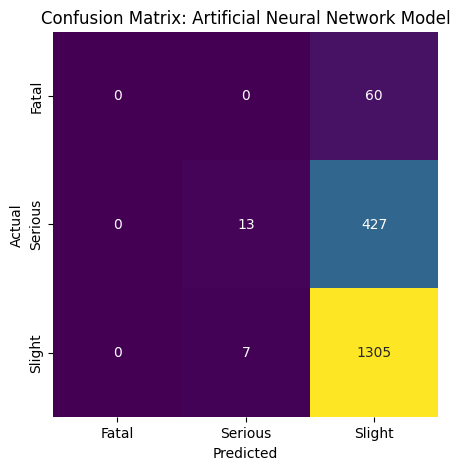

In [56]:
# Data for the confusion matrix
data_matrix = [
[   0,    0,   60],
 [   0,   13,  427],
 [   0,    7, 1305]
]
# Labels for the rows and columns
labels = ['Fatal', 'Serious', 'Slight']

# Convert the list to a pandas DataFrame
df_matrix = pd.DataFrame(data_matrix, index=labels, columns=labels)

# Plotting the confusion matrix using seaborn for better visual representation
plt.figure(figsize=(6, 5))
sns.heatmap(df_matrix, annot=True, fmt="d", cmap='viridis', cbar=False, square=True)
plt.title('Confusion Matrix: Artificial Neural Network Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()